<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/GBM(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Complete GBM Analysis Pipeline
Loading datasets...
Train dataset shape: (3584, 84)
Validation dataset shape: (768, 84)
Test dataset shape: (768, 84)

Creating quantile-based labels...
Quantile thresholds: {'20%': np.float64(550.2), '40%': np.float64(1447.5200000000002), '60%': np.float64(3064.522), '80%': np.float64(6362.600000000002)}

Production category distribution in training data:
Production_Category
High         717
Low          717
Medium       716
Very High    717
Very Low     717
Name: count, dtype: int64

Preparing features...
Feature matrix shape: (3584, 83)
Target classes: ['High', 'Low', 'Medium', 'Very High', 'Very Low']

Training GBM model for 100 epochs...
      Iter       Train Loss   Remaining Time 
         1           1.3824           17.32s
         2           1.2181           16.25s
         3           1.0934           15.87s
         4           0.9910           15.65s
         5           0.9057           15.57s
         6           0.8321           

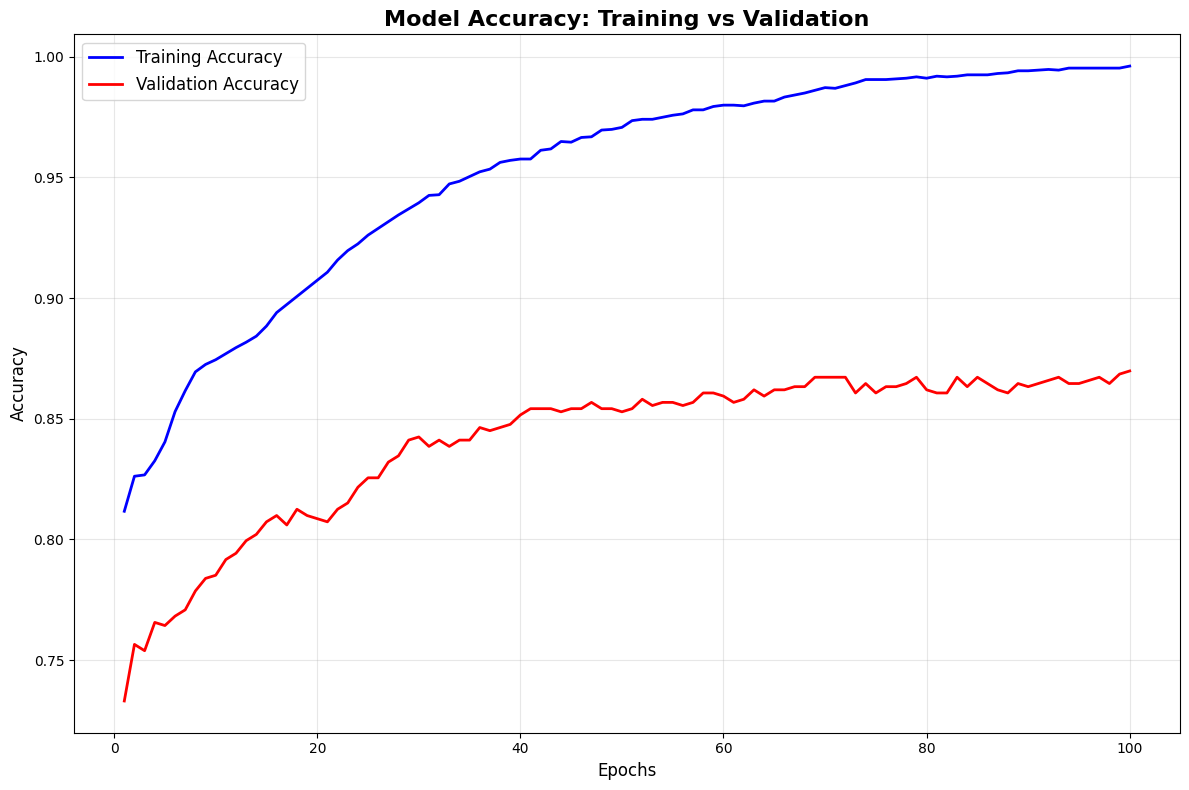


Best validation accuracy: 0.8698 at epoch 100


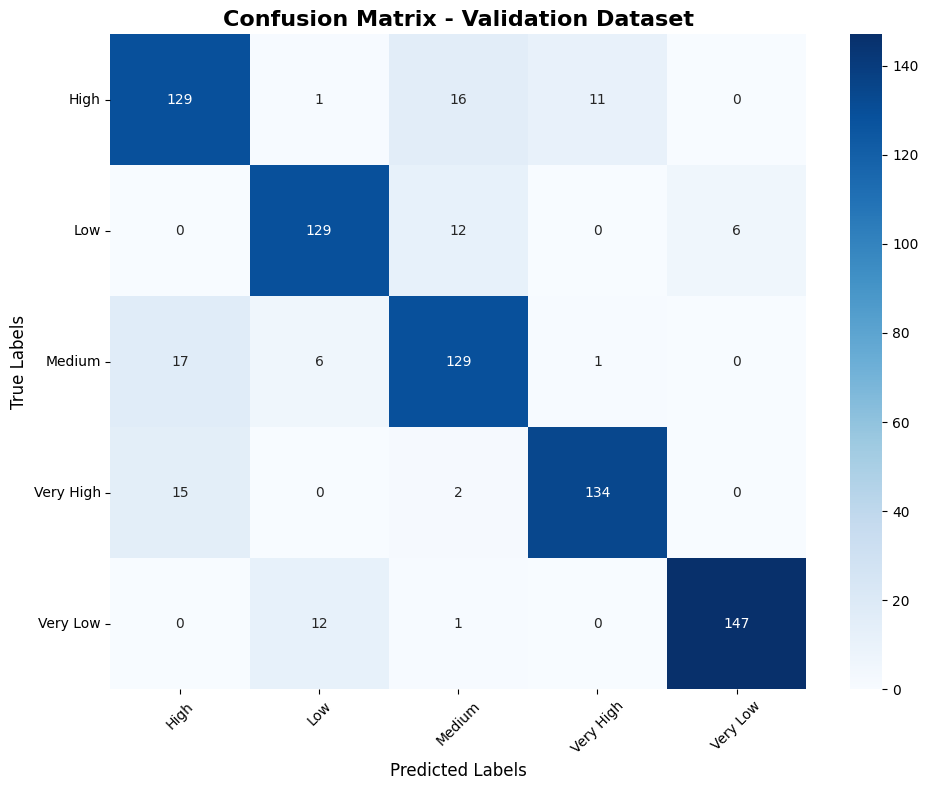

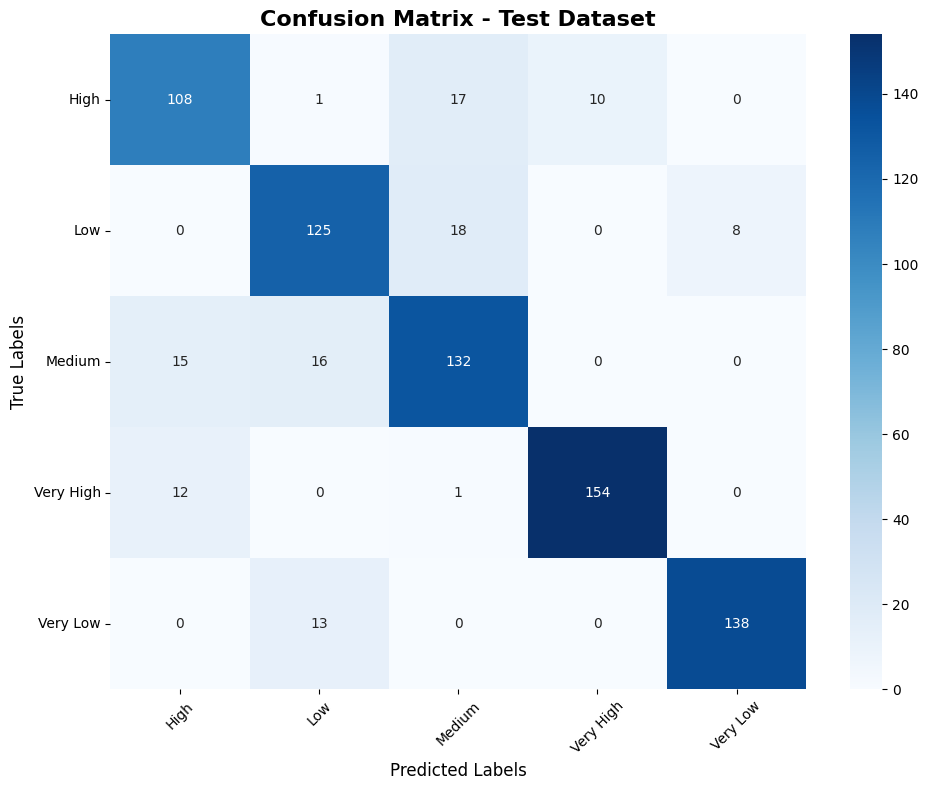

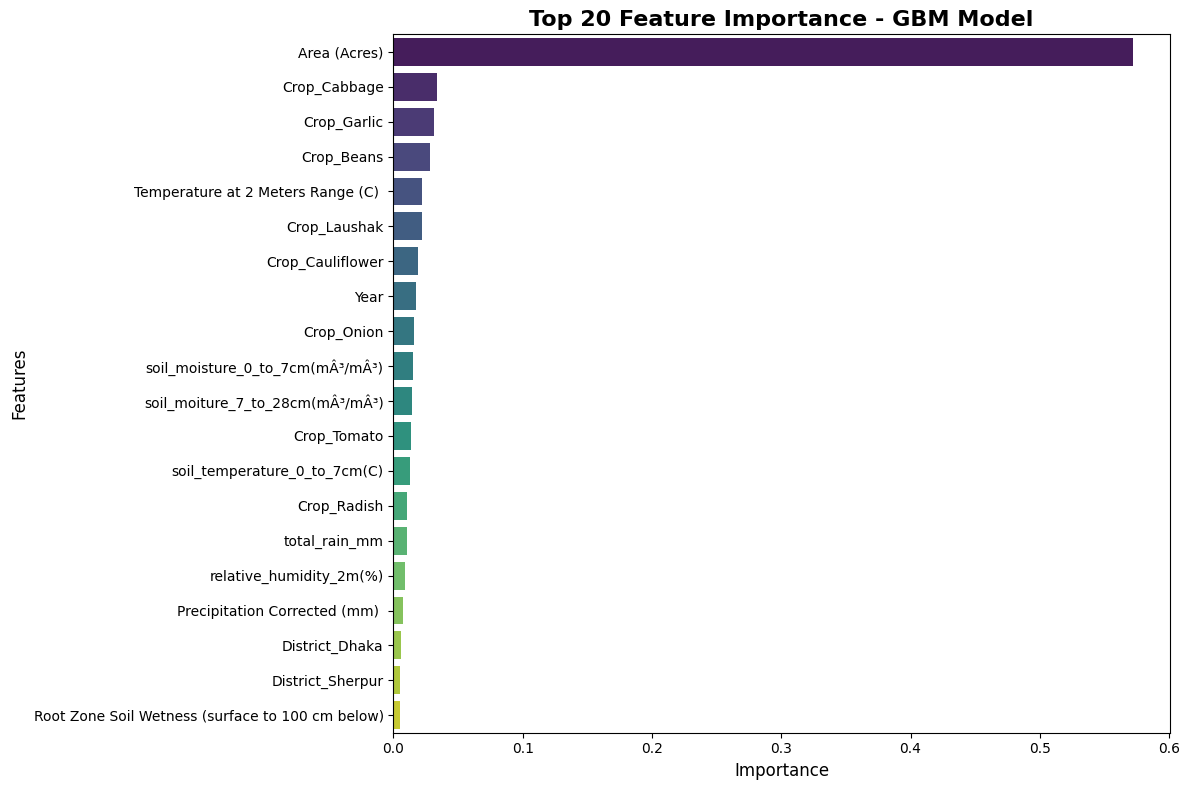


Top 20 Most Important Features:
Area (Acres): 0.5718
Crop_Cabbage: 0.0340
Crop_Garlic: 0.0315
Crop_Beans: 0.0283
Temperature at 2 Meters Range (C) : 0.0224
Crop_Laushak: 0.0219
Crop_Cauliflower: 0.0190
Year: 0.0177
Crop_Onion: 0.0157
soil_moisture_0_to_7cm(mÂ³/mÂ³): 0.0151
soil_moiture_7_to_28cm(mÂ³/mÂ³): 0.0143
Crop_Tomato: 0.0139
soil_temperature_0_to_7cm(C): 0.0127
Crop_Radish: 0.0108
total_rain_mm: 0.0103
relative_humidity_2m(%): 0.0089
Precipitation Corrected (mm) : 0.0071
District_Dhaka: 0.0057
District_Sherpur: 0.0055
Root Zone Soil Wetness (surface to 100 cm below): 0.0050

SUMMARY OF RESULTS
Validation Macro F1 Score: 0.8704
Test Macro F1 Score: 0.8543
Validation Accuracy: 0.8698
Test Accuracy: 0.8555


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

class GBMProductionClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42):
        """
        Initialize GBM classifier with parameters
        """
        self.model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state,
            verbose=1
        )
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.quantiles = None

    def load_data(self, train_path, validation_path, test_path):
        """
        Load and prepare datasets
        """
        print("Loading datasets...")
        self.train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        self.validation_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        self.test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"Train dataset shape: {self.train_df.shape}")
        print(f"Validation dataset shape: {self.validation_df.shape}")
        print(f"Test dataset shape: {self.test_df.shape}")

        return self

    def create_quantile_labels(self):
        """
        Create quantile-based labels for production levels
        """
        print("\nCreating quantile-based labels...")

        # Calculate quantiles from training data
        production_col = 'Production (M.Ton)'
        production_values = self.train_df[production_col]

        self.quantiles = {
            '20%': production_values.quantile(0.2),
            '40%': production_values.quantile(0.4),
            '60%': production_values.quantile(0.6),
            '80%': production_values.quantile(0.8)
        }

        print(f"Quantile thresholds: {self.quantiles}")

        def categorize_production(value):
            if value <= self.quantiles['20%']:
                return 'Very Low'
            elif value <= self.quantiles['40%']:
                return 'Low'
            elif value <= self.quantiles['60%']:
                return 'Medium'
            elif value <= self.quantiles['80%']:
                return 'High'
            else:
                return 'Very High'

        # Apply categorization to all datasets
        self.train_df['Production_Category'] = self.train_df[production_col].apply(categorize_production)
        self.validation_df['Production_Category'] = self.validation_df[production_col].apply(categorize_production)
        self.test_df['Production_Category'] = self.test_df[production_col].apply(categorize_production)

        # Print distribution
        print("\nProduction category distribution in training data:")
        print(self.train_df['Production_Category'].value_counts().sort_index())

        return self

    def prepare_features(self):
        """
        Prepare features for modeling
        """
        print("\nPreparing features...")

        # Drop the original production column and keep category
        feature_cols = [col for col in self.train_df.columns
                       if col not in ['Production (M.Ton)', 'Production_Category']]

        # Prepare features
        self.X_train = self.train_df[feature_cols]
        self.y_train = self.train_df['Production_Category']

        self.X_val = self.validation_df[feature_cols]
        self.y_val = self.validation_df['Production_Category']

        self.X_test = self.test_df[feature_cols]
        self.y_test = self.test_df['Production_Category']

        # Handle any missing values
        self.X_train = self.X_train.fillna(self.X_train.mean())
        self.X_val = self.X_val.fillna(self.X_train.mean())
        self.X_test = self.X_test.fillna(self.X_train.mean())

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Encode labels
        self.y_train_encoded = self.label_encoder.fit_transform(self.y_train)
        self.y_val_encoded = self.label_encoder.transform(self.y_val)
        self.y_test_encoded = self.label_encoder.transform(self.y_test)

        print(f"Feature matrix shape: {self.X_train_scaled.shape}")
        print(f"Target classes: {list(self.label_encoder.classes_)}")

        return self

    def train_model(self, n_epochs=100):
        """
        Train the GBM model with staged predictions for epoch tracking
        """
        print(f"\nTraining GBM model for {n_epochs} epochs...")

        # Set n_estimators to n_epochs for GBM
        self.model.set_params(n_estimators=n_epochs)

        # Train the model
        self.model.fit(self.X_train_scaled, self.y_train_encoded)

        # Get staged predictions for plotting training curves
        train_scores = []
        val_scores = []

        # For GBM, we can get staged predictions
        train_staged_pred = list(self.model.staged_predict(self.X_train_scaled))
        val_staged_pred = list(self.model.staged_predict(self.X_val_scaled))

        for i in range(len(train_staged_pred)):
            train_acc = accuracy_score(self.y_train_encoded, train_staged_pred[i])
            val_acc = accuracy_score(self.y_val_encoded, val_staged_pred[i])
            train_scores.append(train_acc)
            val_scores.append(val_acc)

        self.train_scores = train_scores
        self.val_scores = val_scores

        print("Training completed!")
        return self

    def evaluate_model(self, X, y, y_encoded, dataset_name):
        """
        Evaluate model performance
        """
        # Make predictions
        y_pred_encoded = self.model.predict(X)
        y_pred = self.label_encoder.inverse_transform(y_pred_encoded)

        # Calculate metrics
        accuracy = accuracy_score(y_encoded, y_pred_encoded)

        # Calculate precision, recall, f1 for each class and averages
        precision_macro = precision_score(y_encoded, y_pred_encoded, average='macro')
        precision_weighted = precision_score(y_encoded, y_pred_encoded, average='weighted')

        recall_macro = recall_score(y_encoded, y_pred_encoded, average='macro')
        recall_weighted = recall_score(y_encoded, y_pred_encoded, average='weighted')

        f1_macro = f1_score(y_encoded, y_pred_encoded, average='macro')
        f1_weighted = f1_score(y_encoded, y_pred_encoded, average='weighted')

        # Store results
        results = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'precision_weighted': precision_weighted,
            'recall_macro': recall_macro,
            'recall_weighted': recall_weighted,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'y_true': y,
            'y_pred': y_pred,
            'y_true_encoded': y_encoded,
            'y_pred_encoded': y_pred_encoded
        }

        return results

    def print_classification_metrics(self, results, dataset_name):
        """
        Print classification metrics
        """
        print(f"\n{'='*50}")
        print(f"{dataset_name.upper()} DATASET METRICS")
        print(f"{'='*50}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision (Macro): {results['precision_macro']:.4f}")
        print(f"Precision (Weighted): {results['precision_weighted']:.4f}")
        print(f"Recall (Macro): {results['recall_macro']:.4f}")
        print(f"Recall (Weighted): {results['recall_weighted']:.4f}")
        print(f"F1 Score (Macro): {results['f1_macro']:.4f}")
        print(f"F1 Score (Weighted): {results['f1_weighted']:.4f}")

        # Detailed classification report
        print(f"\nDetailed Classification Report for {dataset_name}:")
        print(classification_report(results['y_true'], results['y_pred']))

    def plot_confusion_matrix(self, results, dataset_name):
        """
        Plot confusion matrix
        """
        plt.figure(figsize=(10, 8))

        # Create confusion matrix
        cm = confusion_matrix(results['y_true'], results['y_pred'])

        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)

        plt.title(f'Confusion Matrix - {dataset_name} Dataset', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_training_curves(self):
        """
        Plot training vs validation accuracy curves
        """
        plt.figure(figsize=(12, 8))

        epochs = range(1, len(self.train_scores) + 1)

        plt.plot(epochs, self.train_scores, 'b-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, self.val_scores, 'r-', label='Validation Accuracy', linewidth=2)

        plt.title('Model Accuracy: Training vs Validation', fontsize=16, fontweight='bold')
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print best validation accuracy
        best_val_epoch = np.argmax(self.val_scores) + 1
        best_val_acc = max(self.val_scores)
        print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_val_epoch}")

    def run_complete_analysis(self, train_path, validation_path, test_path, n_epochs=100):
        """
        Run complete analysis pipeline
        """
        print("Starting Complete GBM Analysis Pipeline")
        print("="*60)

        # Load and prepare data
        (self.load_data(train_path, validation_path, test_path)
         .create_quantile_labels()
         .prepare_features()
         .train_model(n_epochs))

        # Evaluate on all datasets
        print("\nEvaluating model performance...")

        # Validation results
        val_results = self.evaluate_model(
            self.X_val_scaled, self.y_val, self.y_val_encoded, 'Validation'
        )

        # Test results
        test_results = self.evaluate_model(
            self.X_test_scaled, self.y_test, self.y_test_encoded, 'Test'
        )

        # Print metrics
        self.print_classification_metrics(val_results, 'Validation')
        self.print_classification_metrics(test_results, 'Test')

        # Plot results
        print("\nGenerating visualizations...")

        # Training curves
        self.plot_training_curves()

        # Confusion matrices
        self.plot_confusion_matrix(val_results, 'Validation')
        self.plot_confusion_matrix(test_results, 'Test')

        # Feature importance
        self.plot_feature_importance()

        return val_results, test_results

    def plot_feature_importance(self, top_n=20):
        """
        Plot feature importance
        """
        # Get feature importance
        feature_names = self.X_train.columns
        importance = self.model.feature_importances_

        # Create dataframe and sort
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        # Plot top N features
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)

        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance - GBM Model', fontsize=16, fontweight='bold')
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

        print(f"\nTop {top_n} Most Important Features:")
        for i, row in top_features.iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

# Example usage and execution
if __name__ == "__main__":
    # Initialize the classifier
    gbm_classifier = GBMProductionClassifier(
        n_estimators=100,  # Will be overridden by n_epochs in training
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )

    # File paths - Update these with your actual file paths
    train_path = 'train.csv'
    validation_path = 'validation.csv'
    test_path = 'test.csv'

    try:
        # Run complete analysis
        val_results, test_results = gbm_classifier.run_complete_analysis(
            train_path=train_path,
            validation_path=validation_path,
            test_path=test_path,
            n_epochs=100  # Number of boosting rounds
        )

        print("\n" + "="*60)
        print("SUMMARY OF RESULTS")
        print("="*60)
        print(f"Validation Macro F1 Score: {val_results['f1_macro']:.4f}")
        print(f"Test Macro F1 Score: {test_results['f1_macro']:.4f}")
        print(f"Validation Accuracy: {val_results['accuracy']:.4f}")
        print(f"Test Accuracy: {test_results['accuracy']:.4f}")

    except FileNotFoundError as e:
        print(f"Error: Could not find CSV file. Please ensure the following files exist:")
        print(f"- {train_path}")
        print(f"- {validation_path}")
        print(f"- {test_path}")
        print(f"\nActual error: {e}")

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check your data format and try again.")

# Additional utility functions for further analysis
def compare_models_performance(val_results, test_results):
    """
    Compare validation vs test performance
    """
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    comparison_df = pd.DataFrame({
        'Validation': [val_results[metric] for metric in metrics],
        'Test': [test_results[metric] for metric in metrics]
    }, index=[metric.replace('_', ' ').title() for metric in metrics])

    # Plot comparison
    comparison_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance: Validation vs Test', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison_df

def save_results_to_csv(val_results, test_results, filename='model_results.csv'):
    """
    Save results to CSV file
    """
    results_summary = {
        'Dataset': ['Validation', 'Test'],
        'Accuracy': [val_results['accuracy'], test_results['accuracy']],
        'Precision_Macro': [val_results['precision_macro'], test_results['precision_macro']],
        'Recall_Macro': [val_results['recall_macro'], test_results['recall_macro']],
        'F1_Macro': [val_results['f1_macro'], test_results['f1_macro']],
        'F1_Weighted': [val_results['f1_weighted'], test_results['f1_weighted']]
    }

    results_df = pd.DataFrame(results_summary)
    results_df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

    return results_df